In [388]:
# Ignore unnecessary padas warnings
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# API
import requests
import json

# AquaCrop
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement

# General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

### Prepare Input Data

In [65]:
# Load and preprocess data
refEt = pd.read_csv("fourierEt.csv")
weather = pd.read_csv("weather.csv")
weather["refEt"] = refEt
weather["date"] = pd.to_datetime(weather["date"], format= "%Y-%m-%d")

# Get data for a given year + format to AquaCrop specifications
def getYear(weather, year):
    weather = weather.loc[pd.DatetimeIndex(weather.date).year == year]
    
    weather = weather.loc[:, ("temp_min", "temp_max", "rain", "refEt", "date")]
    weather.columns = ["MinTemp", "MaxTemp", "Precipitation", "ReferenceET", "Date"]
    weather.reset_index(drop = True, inplace = True)
    
    return weather

weather = getYear(weather, 2010)
weather

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,22.2,32.3,13.4,4.03,2010-01-01
1,16.3,23.3,21.8,5.00,2010-01-02
2,12.6,23.2,0.0,6.53,2010-01-03
3,12.7,28.9,0.0,6.48,2010-01-04
4,14.8,32.6,0.0,7.80,2010-01-05
...,...,...,...,...,...
360,10.5,18.0,0.0,5.41,2010-12-27
361,8.5,24.0,0.0,6.04,2010-12-28
362,13.0,28.9,0.0,6.68,2010-12-29
363,14.9,30.8,0.0,7.03,2010-12-30


### Define state space
- **RZSMD**: root zone soil moisture deficit (mm)
- **D**: current timestep RZSMD (mm)
- **D+**: next timestep RZSMD (mm)
- **E**: current timestep Evapotranspiration (mm)
- **I**: current timestep Irrigation (mm)
- **P**: current timestep Rainfall (mm)

$$
D^+=c_1D + c_2E + c_3P + c_4I
$$

*deep percolation and water runoff are neglected

The coefficients $c_1$ to $c_4$ need to be identified as they define the contribution to current timestep's RZSMD from the previous day, the correction factor on calculated Evapotranspiration, the effectivness of Rainfall, and the efficiency of Irrigation. To identify them we run an AquaCrop model with data from the previous season based on which we get the value of RZSMD for each day. Using these values we find the coefficients $c_{1:4}$ that minimize the squared deviations between RZSMD data and our state-space predictions. We ignore the deep percolation and run-off for two reasons: first, unless it's heavy rain, they are negligible. Second, they are not easy to measure with sensors, hence it is an unrealistic input metric in a real-life application.

### Irrigation method during model identification phase

To identify the above coefficients we must run an AquaCrop simulation with some irrigation method. Delgoda et. al. choose to use a rule-based irrigation where irrigation is applied whenever water depletion in readily available water (RAW) exceeds 10%. This means we irrigate the crop whenever its available water content drops below 90%. The RAW depends on the total available water (TAW) content, the rooting depth of the crop, and the current referrence evapotraspiration (refET).

Since this method is not natively implemented in the Python version of AquaCrop, we must define it ourselves. To determine wheter the depletion exceeded 10% of RAW we first need to compute the RAW value for our soil and crop and then compare this value witht he current water content in the soil. Python implemented AquaCrop model gives us the TAW value, but not the RAW. Thus we first use a coefficient $p$ given by [FAO guidlines](https://www.fao.org/3/x0490e/x0490e0e.htm) for our crop to calculate $RAW = p \times TAW$. At each time step of the simulation we then measure the current water content, compare it with RAW, and when it is less than 90% of RAW, we irrigate enough water to get the total water content back to 100% of RAW.

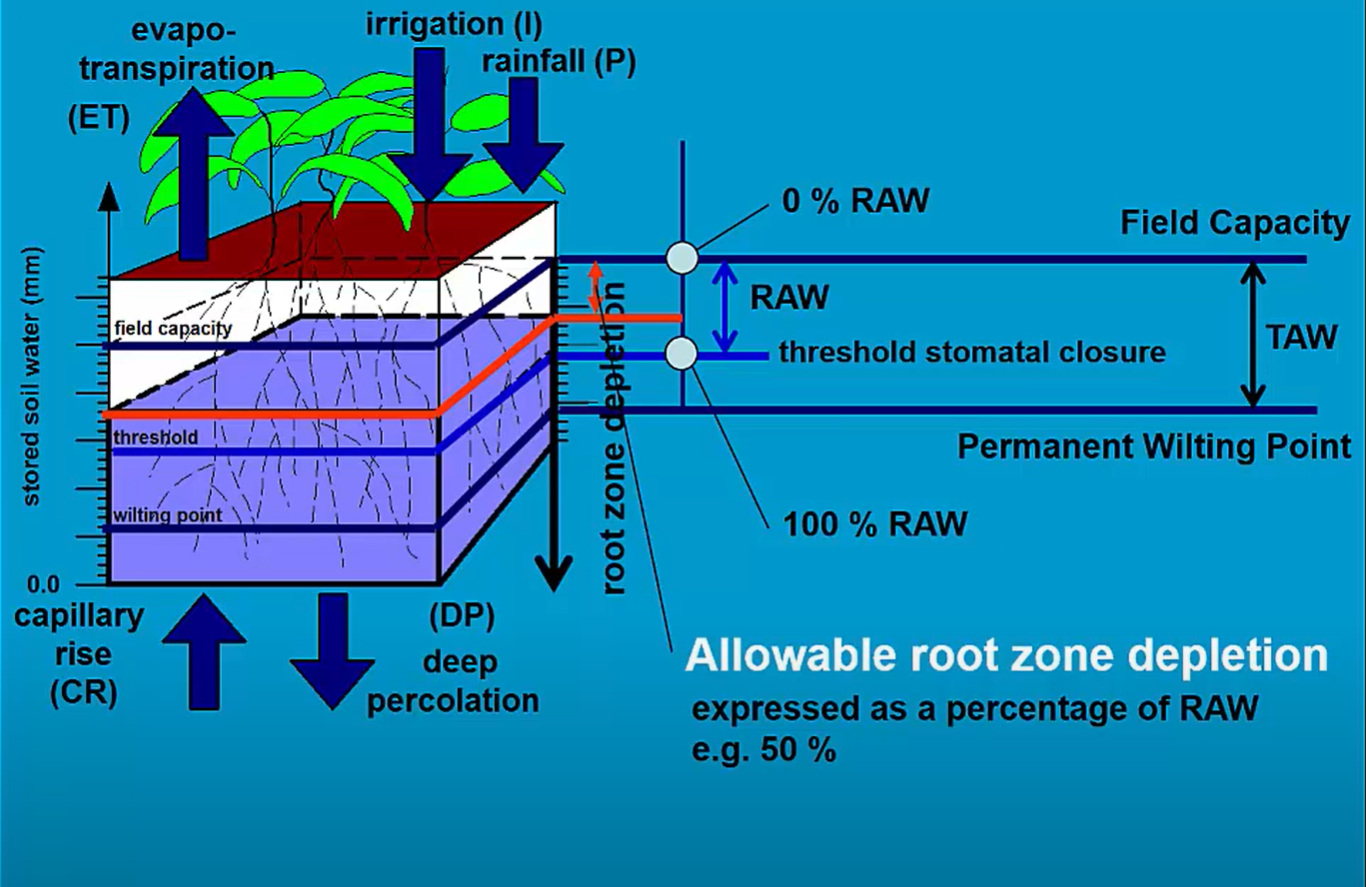

*Screenshot from a [video](https://www.youtube.com/watch?v=oLqhKYFdnXs) explaining % of RAW irrigation rule

### Define AquaCrop Model
Here we use  the same crop, soil, and irrigation management set up as Delgoda et. al.. The weather data is loaded from Open-Meteo with location set to the Australian town of Shepparton between the years 2010 and 2011

In [389]:
# Define model parameters
soil = Soil(soil_type = 'Loam')
crop = Crop('Tomato', planting_date = '08/01', harvest_date = '11/18')
init_water = InitialWaterContent(value = ['FC'])
weather_df = weather
sim_start_time = "2010/08/01"
sim_end_time = "2010/11/18"

# Define Irrigation Management method
# We irrigate whenever TAW is below 90%
irrMng = IrrigationManagement(irrigation_method = 5, )

# Build a field model
model = AquaCropModel(sim_start_time = sim_start_time,
                      sim_end_time = sim_end_time,
                      weather_df = weather_df,
                      soil = soil,
                      crop = crop,
                      initial_water_content = init_water, 
                      irrigation_management = irrMng)

In [423]:
def getRaw(p, model, verbose = False):
    # Get TAW
    TAW = model._init_cond.taw
    
    if verbose:
        print(f"The current TAW is {round(TAW, 3)}")
    
    # Adjust coefficient based on current evapotranspiration
    p = p + 0.04 * (5 - model._init_cond.et0)
    
    # Calculate RAW
    RAW = p * TAW
    
    if RAW != 0:
        return RAW
    else:
        return 1

def getDepletionOfRaw(p, model, verbose = False):
    RAW_mm = getRaw(p, model, verbose)
    depletion_mm = model._init_cond.depletion # calculated as min(FieldCap - Actual Water Content, TAW)
                                              # hence negative values mean ActW is more than FC and there's no depletion
                                              # and positive values < TAW mean there's depletion
    if verbose:
        print(f"The current depletion is {round(depletion_mm, 3)}mm")
        
    if depletion_mm < 0:
        return 0
    else:
        depletion = depletion_mm / RAW_mm     # depletion as % of RAW
        return depletion

def getDepth(p, model, verbose = False):
    depletion = getDepletionOfRaw(p, model, verbose)
    
    if depletion <= 0:
        depth = 0
    elif depletion >= 0.1:
        depth = model._init_cond.depletion
    else:
        depth = 0
        
    if verbose:
        print(f"We will irrigate {round(depth, 3)}mm\n")
        
    return depth

def adjustP(p, model):
    refEt = model._init_cond.et0
    
    return p + 0.04 * (5 - refEt) # Ref: https://www.fao.org/3/x0490e/x0490e0e.htm


Total irrigation amounted to 276.608mms
In addition, it rained a total of 348.3mms



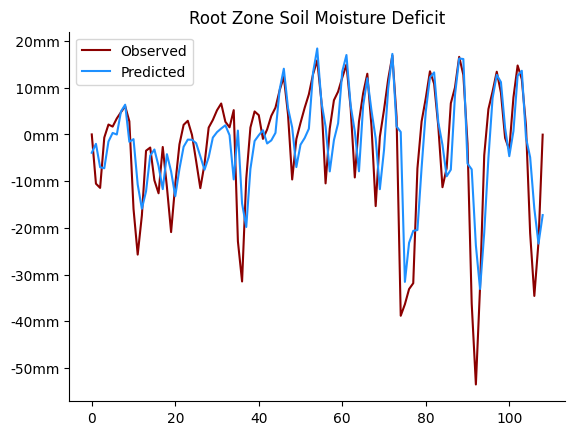

In [462]:
# Initialize a field model
model._initialize()

# Set coefficient p of the crop for calculation of RAW from TAW
tomato_p = 0.4   # https://www.fao.org/3/x0490e/x0490e0e.htm

# Run the model    
D = [0]
while model._clock_struct.model_is_finished is False:    
    
    # Calc irrigation amount based on depletion
    p = adjustP(tomato_p, model)
    depth = getDepth(p, model, verbose = False)
    D.append(model._init_cond.depletion)
    
    # Irrigate calculated amount
    model._param_struct.IrrMngt.depth = depth
    
    # Advance the simulation 1 step forward
    model.run_model(initialize_model = False)
    
# Save the output
D = np.array(D)
I = np.array(model._outputs.water_flux.IrrDay)
P = model._weather[:, 2]
E = model._weather[:, 3]

print(f"\nTotal irrigation amounted to {round(model._outputs.final_stats.iloc[:, -1].values[0], 3)}mms")
print(f"In addition, it rained a total of {round(model._weather[:, 2].sum(), 3)}mms\n")

# Calculate the coefficients of our equation
y = D[1:]
X = np.array([D, E, P, I], dtype = "float64").T[:-1]
c = np.linalg.inv(X.T@X)@X.T@y

# Plot the predictions vs. targets
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(1, 1)

ax.plot(D[1:], c = "darkred", label = "Observed")
ax.plot(c@X.T, c = "dodgerblue", label = "Predicted")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fmtr = StrMethodFormatter("{x: g}mm")
ax.yaxis.set_major_formatter(fmtr)

ax.set_title(f"Root Zone Soil Moisture Deficit")
ax.legend()
    
plt.show()

In [435]:
# Calculating the coefficients also with Statsmodels to get R2, std. errors, and CIs
import statsmodels.api as sm

y = D[1:]
X = np.array([D, E, P, I], dtype = "float64").T[:-1]

linReg = sm.OLS(y, X)
res = linReg.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.559
Model:                            OLS   Adj. R-squared (uncentered):              0.542
Method:                 Least Squares   F-statistic:                              33.26
Date:                Sun, 05 Feb 2023   Prob (F-statistic):                    6.62e-18
Time:                        21:04:29   Log-Likelihood:                         -398.22
No. Observations:                 109   AIC:                                      804.4
Df Residuals:                     105   BIC:                                      815.2
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

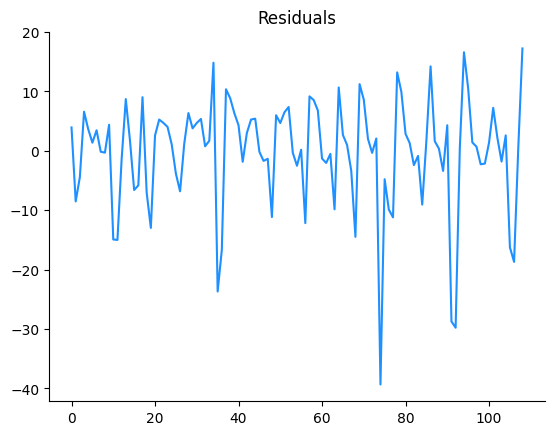

In [447]:
# Plot the residuals
fig, ax = plt.subplots(1, 1)
plt.plot(res.resid, c = "dodgerblue", label = "Residuals")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title(f"Residuals")

plt.show()

In [451]:
# Final harvest
model._outputs.final_stats

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Tomato,2010-11-18,108,4.872289,276.608191


###  Notes for self
- clearly OLS is not the best fit for model identification, there's a pattern in residuals that can be better fitted
- look into Kalman filters as a remedy
- Delgoda et. al. don't talk about this aspect at all